In [44]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))
from visualization.utils import defaultColors
from helpers import load_from_path, save_pdf

In [45]:
from mobo.surrogate_model import BoTorchSurrogateModelReapeatMean, BoTorchSurrogateModelMean, BoTorchSurrogateModel
import numpy as np
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import yaml

In [46]:
# path = Path("../result/exp4d/unroll_new/marsdet/0/")
# path = Path("../result/exp/unroll_new/raqnehvi/0/")
# path = Path("../result/peaksS5R3/default/mars/0/")
# path = Path("../result/peaks/default/qnehvi/0/")
# good results\peaks\risk-averse1\qnehvi\0)
path = Path("../good results/peaks/risk-averse1/qnehvi/0/")

res_dict = load_from_path(path)
eval_samples = res_dict["eval_samples"]
n_obj = res_dict["n_obj"]
sobol = res_dict["sobol"]

# train_X = eval_samples[["x1", "x2", "x3", "x4"]].values
# use pandas filter to select columns
train_X = eval_samples.filter(regex="^x[0-9]").values
train_Y = eval_samples.filter(regex="^f[0-9]").values
train_Yvar = eval_samples.filter(regex="^rho_f[0-9]").values

# min max bounds from train_X
bounds = np.stack([train_X.min(0), train_X.max(0)])

In [47]:
import torch
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt

# Assuming train_X, train_Y, and train_Yvar are already defined tensors as per your setup

normalization = StandardTransform(bounds)


train_X = normalization.do(train_X)
# LOOCV
loo = LeaveOneOut()
pred_Y = np.zeros_like(train_Y)
Y = np.zeros_like(train_Y)
Yvar = np.zeros_like(train_Yvar)

for train_index, test_index in loo.split(train_X):
    X_train, X_test = train_X[train_index], train_X[test_index]
    Y_train, Y_test = train_Y[train_index], train_Y[test_index]
    Yvar_train, Yvar_test = train_Yvar[train_index], train_Yvar[test_index] 

    # Initialize and fit the model
    sm = BoTorchSurrogateModel(n_var=X_train.shape[-1], n_obj=Y_train.shape[-1], n_w=11, alpha=0.9)
    sm.fit(X_train, Y_train, Yvar_train)

    # Evaluate the model on the test set
    res = sm.evaluate(X_test, noise=True, std=True)
    pred_Y[test_index] = res["F"]
    Y[test_index] = Y_test
    
    pred_Yvar = res["S"]**2
    Yvar = Yvar_test


rho statistics
mean: 0.10745038386090194, std: 0.1216300519268469, min: 2.94085756710256e-12, max: 0.4219127350200429
mean: 0.1014379103279874, std: 0.11275493200317953, min: 1.0427823223229964e-11, max: 0.3245840698974866
rho statistics
mean: 0.10870157234232128, std: 0.12071400679561335, min: 2.94085756710256e-12, max: 0.4219127350200429
mean: 0.10184120971179754, std: 0.11240614440828994, min: 1.0427823223229964e-11, max: 0.3245840698974866
rho statistics
mean: 0.10869401075688709, std: 0.1207210072046776, min: 2.94085756710256e-12, max: 0.4219127350200429
mean: 0.10183883973007683, std: 0.11240835384411264, min: 1.0427823223229964e-11, max: 0.3245840698974866
rho statistics
mean: 0.10427206255829825, std: 0.12180340405138111, min: 2.94085756710256e-12, max: 0.4219127350200429
mean: 0.09735373088325541, std: 0.11326859222404863, min: 1.0427823223229964e-11, max: 0.3245840698974866
rho statistics
mean: 0.10870156255162346, std: 0.12071401587131494, min: 2.94085756710256e-12, max: 0.4

Mean Absolute Percentage Error for each objective: [255.55911669 212.18390236]
Mean Absolute Error for each objective: [0.09480989 0.13060971]


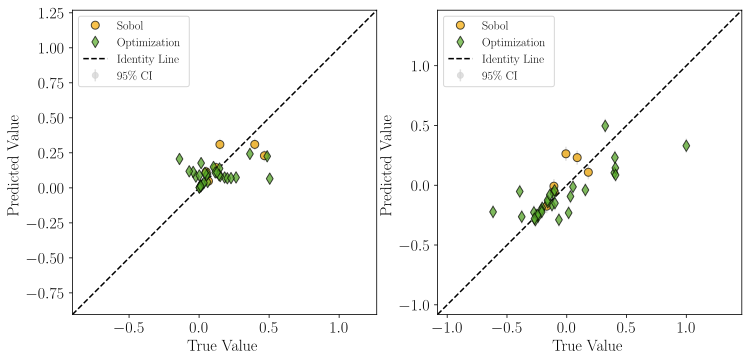

In [48]:

%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Helvetica"],
    # font size
    "font.size": 16,
})

pred_Ystd = np.sqrt(pred_Yvar)



color_list = defaultColors

# Prepare the plot
fig, ax = plt.subplots(1, n_obj, 
                       figsize=(3*n_obj + 6, 6),
                       dpi=600)

for i in range(n_obj):
    
    # Error bars for confidence intervals
    # Scatter plot for predictions vs. true values
    ax[i].errorbar(Y[:, i], pred_Y[:, i], yerr=pred_Ystd[:, i], fmt='o', color="lightgray", alpha=0.7, label="95\% CI")
    # ax[i].plot(train_Y[:, i], pred_Y[:, i], alpha=0.9, color=colors, markeredgecolor="black", linestyle="None", marker="o", markersize=8,
    #               zorder=5,)
    
    # Sobol experiments
    ax[i].plot(Y[sobol, i], pred_Y[sobol, i], alpha=0.7, color=color_list[0], markeredgecolor="black", linestyle="None", marker="o", markersize=8,
                    zorder=5, label="Sobol")
    # Optimization experiments
    ax[i].plot(Y[~sobol, i], pred_Y[~sobol, i], alpha=0.7, color=color_list[1], markeredgecolor="black", linestyle="None", marker="d", markersize=8,
                    zorder=5, label="Optimization")
    
    
    # Identity line
    max_val = max(max(Y[:, i]), max(pred_Y[:, i])) + Yvar[:, i].mean() * 2
    min_val = min(min(Y[:, i]), min(pred_Y[:, i])) - Yvar[:, i].mean() * 2
    ax[i].plot([min_val, max_val], [min_val, max_val], 'k--', label="Identity Line")
    
    # Set limits for better comparison
    # ax[i].set_xlim([ 0, max_val])
    # ax[i].set_ylim([ 0, max_val])
    ax[i].set_xlim([ min_val, max_val])
    ax[i].set_ylim([ min_val, max_val])
    
    # Enhance labeling
    ax[i].set_xlabel("True Value")
    ax[i].set_ylabel("Predicted Value")
    # ax[i].set_title(f"Objective {i+1} Parity Plot")
    ax[i].set_aspect('equal', adjustable='box')

    #empty plot for legend
    # marker with outline in black
    
    ax[i].legend(fontsize=12, loc="upper left")
    

save_pdf(fig, path, "parity_plot")

# Calculate and print MAPE for each objective
mape = np.mean(np.abs((Y - pred_Y) / Y), axis=0) * 100
mae = np.mean(np.abs(Y - pred_Y), axis=0)
 
print("Mean Absolute Percentage Error for each objective:", mape)
print("Mean Absolute Error for each objective:", mae)